## 0 Imports and Constants

In [1]:
## 0 Imports and Constants
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_clas, train_test_split, accuracy
from data_evaluation.visual.visual_evaluation import visual_evaluation
from data_evaluation.predictive.predictive_evaluation import predictive_evaluation
from data_evaluation.discriminative.discriminative_model import LSTMClassification, CNNClassification, train_cnn
from predictive.LSTM import train_model
from predictive.TimeSeriesDataset import TimeSeriesDataset

DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

In [2]:
MODEL = "lstm"

if MODEL == "lstm":
    hyperparameters = {
        "lr": 0.0001,
        "batch_size": 32,
        "hidden_size": 8,
        "num_layers": 1,
        "bidirectional": True,
        "output_logits": True,
        "num_epochs": 10000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

elif MODEL == "cnn":
    hyperparameters = {
        "lr": 0.00001,
        "batch_size": 32,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

## 1 Loading Data

In [3]:
data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_42000_13_5.csv', shape=(42000, 13, 5))

In [4]:
train, test = train_test_split(data, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [5]:
X_batch_train, y_batch_train, X_test, y_test, X_batch_val, y_batch_val = extract_features_and_targets_clas(train, test, val)

In [6]:
scaler = Scaler(X_batch_train)

In [7]:
X_batch_train = scaler.scale_data(X_batch_train)
X_test = scaler.scale_data(X_test)
X_batch_val = scaler.scale_data(X_batch_val)

In [8]:
# put data on tensors (since they had to be numpy arrays for the scaler)
X_batch_train = torch.tensor(X_batch_train, dtype=torch.float32)
y_batch_train = torch.tensor(y_batch_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_batch_val = torch.tensor(X_batch_val, dtype=torch.float32)
y_batch_val = torch.tensor(y_batch_val, dtype=torch.float32)

In [9]:
train_dataset = TimeSeriesDataset(X_batch_train, y_batch_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_batch_val, y_batch_val)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

## 2 Training the model

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []

In [12]:
if MODEL == 'lstm':

    model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_batch_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])

    train_losses, train_accs, val_losses, val_accs, model = train_model(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=hyperparameters["device"],
                        num_epochs=hyperparameters["num_epochs"],
                        verbose=True)
    
elif MODEL == 'cnn':

    ### Model ### 
    model = CNNClassification(verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

    train_losses, val_losses, train_accs, val_accs, model = train_cnn(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
    )

Epoch: 1
Training Loss: 0.6989030355215072
Training Loss: 0.6934403055906295
Training Loss: 0.693635082244873
Training Loss: 0.693873715698719
Training Loss: 0.693276754617691
Validation Loss: 0.69280185843959
Validation Accuracy: 50.87594696969697
**************************************************
Epoch: 2
Training Loss: 0.6966294959187508
Training Loss: 0.6931165623664856
Training Loss: 0.6932377749681473
Training Loss: 0.6931807661056518
Training Loss: 0.6933857855200768
Validation Loss: 0.6928206546740099
Validation Accuracy: 50.85227272727273
INFO: Validation loss did not improve in epoch 2
**************************************************
Epoch: 3
Training Loss: 0.6964938244223595
Training Loss: 0.6931230336427688
Training Loss: 0.6931737753748893
Training Loss: 0.6930707496404648
Training Loss: 0.6933550959825516
Validation Loss: 0.6927732608535073
Validation Accuracy: 50.87594696969697
**************************************************
Epoch: 4
Training Loss: 0.696436633169651

## 3 Evaluate Training

Text(0.5, 1.0, 'Validation Accuracy')

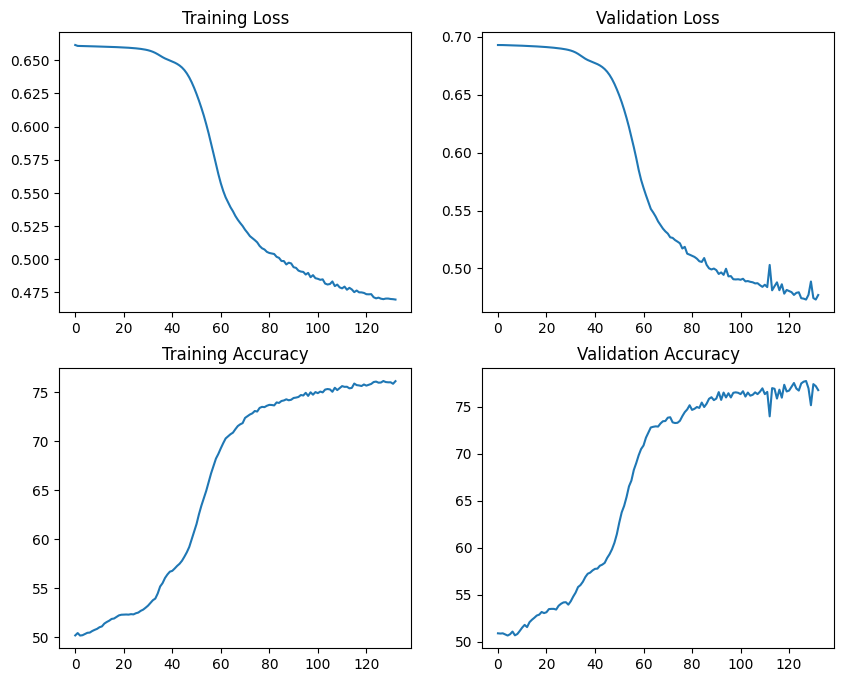

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

In [17]:
autoencoder_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'autoencoder' / 'discriminative_test_autoencoder_3000_13_5.csv', shape=(3000, 13, 5))
jitt_01_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'jitter_01' / 'discriminative_test_jitt_01_3000_13_5.csv', shape=(3000, 13, 5))
jitt_02_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'jitter_02' / 'discriminative_test_jitt_02_3000_13_5.csv', shape=(3000, 13, 5))
jitt_005_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'jitter_005' / 'discriminative_test_jitt_005_3000_13_5.csv', shape=(3000, 13, 5))
timegan_gru_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'timegan_gru' / 'discriminative_test_timegan_gru_3000_13_5.csv', shape=(3000, 13, 5))
timegan_lstm_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'timegan_lstm' / 'discriminative_test_timegan_lstm_3000_13_5.csv', shape=(3000, 13, 5))
timewarp_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / 'timewarp' / 'discriminative_test_timewarp_3000_13_5.csv', shape=(3000, 13, 5))

In [18]:
results = pd.DataFrame(columns=['Method', 'Accuracy'])

In [41]:
def get_discriminative_test_performance(model, test_data, method, results):

    X_test, y_test = extract_features_and_targets_clas(test_data)
    X_test = scaler.scale_data(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    with torch.inference_mode(): 
        test_logits = model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        print(test_acc)
        
        results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)

    return results

In [42]:
X_test, y_test = extract_features_and_targets_clas(autoencoder_test)
X_test = scaler.scale_data(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

with torch.inference_mode(): 
    test_logits = model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
    test_probs = torch.sigmoid(test_logits) # get probabilities
    test_preds = torch.round(test_probs) # get classes
    test_preds = test_preds.clone().detach()

    print(y_test[:20])
    print(test_preds[:20])

    test_acc = accuracy(y_true=y_test, y_pred=test_preds)
    print(test_acc)

Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]])
32.0


In [43]:
results = get_discriminative_test_performance(model, autoencoder_test, 'Autoencoder', results)
results = get_discriminative_test_performance(model, jitt_01_test, 'Jitter 0.1', results)
results = get_discriminative_test_performance(model, jitt_02_test, 'Jitter 0.2', results)
results = get_discriminative_test_performance(model, jitt_005_test, 'Jitter 0.05', results)
results = get_discriminative_test_performance(model, timegan_gru_test, 'TimeGAN GRU', results)
results = get_discriminative_test_performance(model, timegan_lstm_test, 'TimeGAN LSTM', results)
results = get_discriminative_test_performance(model, timewarp_test, 'Timewarp', results)

Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
32.0
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
98.63333333333333
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
99.86666666666667
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
95.76666666666667
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
70.96666666666667
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
97.13333333333334
Extracted features and target from training data.
Shape of X_train: (3000, 12, 5)
Shape of y_train: (3000, 1)
18.7


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_16397/3364649101.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_16397/3364649101.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_16397/3364649101.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y

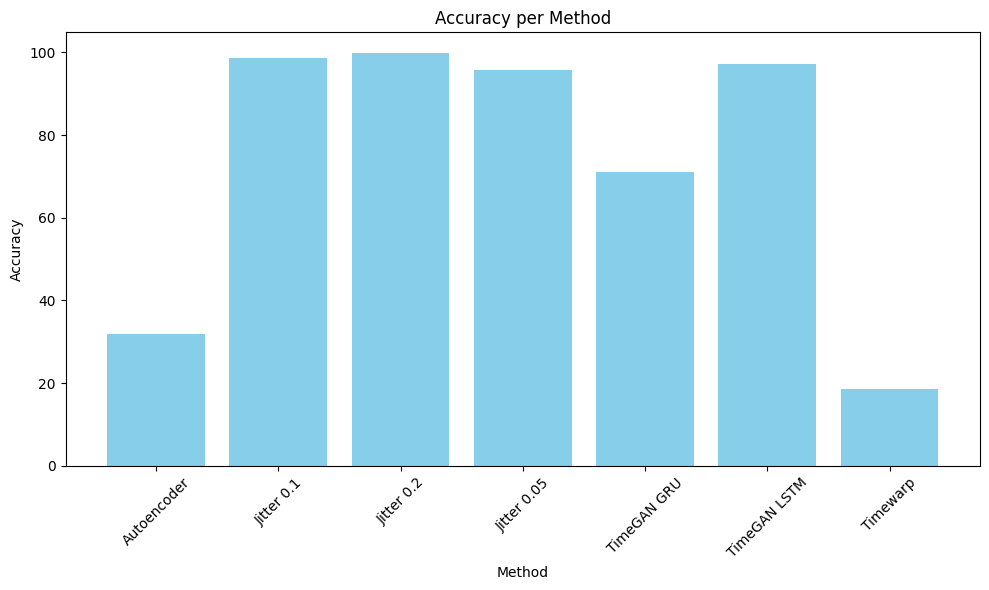

In [44]:
plt.figure(figsize=(10, 6))
plt.bar(results['Method'], results['Accuracy'], color='skyblue')

# Diagramm anpassen
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy per Method')
plt.xticks(rotation=45)  # Optional: Dreht die Beschriftungen der x-Achse um 45 Grad
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [45]:
results

,Method,Accuracy
0,Autoencoder,0.000000
1,Jitter 0.1,0.000000
2,Jitter 0.2,0.000000
3,Jitter 0.05,0.000000
4,TimeGAN GRU,0.000000
5,TimeGAN LSTM,0.000000
6,Timewarp,0.000000
7,Autoencoder,32.000000
8,Jitter 0.1,98.633333
9,Jitter 0.2,99.866667


In [ ]:
results.to_csv(f'{MODEL}_results.csv', index=False)

In [46]:
torch.save(model.state_dict(), f'{MODEL}_model.pth')